In [548]:
# Bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import torch
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from torch import nn

In [549]:
# Carregando dados
inputData = pd.read_csv('./Datasets/mobile/train.csv')
data = inputData.drop('price_range', axis=1)
labels = inputData['price_range']

In [550]:
# Dividir para treinamento e validação
data = data.values
labels = labels.values
data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.2, random_state=123)
data_train, data_validation, labels_train, labels_validation =train_test_split(data_train, labels_train, test_size=0.2)

In [551]:
#One hot encoding
labels_train_onehot = to_categorical(labels_train)
labels_test_onehot = to_categorical(labels_test)
labels_validation_onehot = to_categorical(labels_validation)

In [552]:
data_train = torch.FloatTensor(data_train)
data_test = torch.FloatTensor(data_test)
labels_train = torch.FloatTensor(labels_train)
labels_test = torch.FloatTensor(labels_test)
labels_train_onehot = torch.FloatTensor(labels_train_onehot)
labels_test_onehot = torch.FloatTensor(labels_test_onehot)
#data_validation = torch.FloatTensor(data_validation)
#labels_validation = torch.FloatTensor(labels_validation)

In [553]:
# Rede Neural
class MobilePriceClassifier(nn.Module) :
    def __init__(self, input_size = 20, hidden_size1 = 20, hidden_size2 = 40, hidden_size3 = 20, hidden_size4 = 10, output_size=4) :
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.layer3 = nn.Linear(hidden_size2, hidden_size3)
        self.layer4 = nn.Linear(hidden_size3, hidden_size4)
        self.layer5 = nn.Linear(hidden_size4, output_size)

    def forward(self, data) :
        data = F.relu(self.layer1(data))
        data = F.relu(self.layer2(data))
        data = F.relu(self.layer3(data))
        data = F.relu(self.layer4(data))
        data = self.layer5(data)
        return data

In [554]:
rna = MobilePriceClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rna.parameters(), lr=0.01)

In [555]:
def train_network(model, optimizer, criterion, data_train, labels_train, data_test, labels_test, num_epochs, train_losses, test_losses) :
    for i in range(num_epochs) :
        optimizer.zero_grad()
        label_train = model.forward(data_train) # Pegando a previsão
        loss_train = criterion(label_train, labels_train)
        loss_train.backward()
        optimizer.step()
        
        label_test = model(data_test)
        loss_test = criterion(label_test, labels_test)
        
        train_losses.append(loss_train.detach().numpy())
        test_losses.append(loss_test.detach().numpy())

        if i%25 == 0 :
            print(f'Época {i}, Erro de Treinamento : {loss_train}, Erro de Validação : {loss_test}')

In [556]:
num_epochs = 500
train_losses = []
test_losses = []

In [557]:
train_network(rna, optimizer, criterion, data_train, labels_train_onehot, data_test, labels_test_onehot, num_epochs, train_losses, test_losses)

Época 0, Erro de Treinamento : 15.299372673034668, Erro de Validação : 21.002939224243164
Época 25, Erro de Treinamento : 1.0619539022445679, Erro de Validação : 1.0413144826889038
Época 50, Erro de Treinamento : 0.824994683265686, Erro de Validação : 0.8209263682365417


Época 75, Erro de Treinamento : 0.7429043650627136, Erro de Validação : 0.719612717628479
Época 100, Erro de Treinamento : 0.6606330871582031, Erro de Validação : 0.6416501402854919
Época 125, Erro de Treinamento : 0.6002249717712402, Erro de Validação : 0.5925775766372681
Época 150, Erro de Treinamento : 0.636623203754425, Erro de Validação : 0.6709652543067932
Época 175, Erro de Treinamento : 0.5729057192802429, Erro de Validação : 0.5557002425193787
Época 200, Erro de Treinamento : 0.5302587151527405, Erro de Validação : 0.5237402319908142
Época 225, Erro de Treinamento : 0.5127739906311035, Erro de Validação : 0.5134384036064148
Época 250, Erro de Treinamento : 0.49472177028656006, Erro de Validação : 0.5176033973693848
Época 275, Erro de Treinamento : 0.49205687642097473, Erro de Validação : 0.5019993782043457
Época 300, Erro de Treinamento : 0.4727948009967804, Erro de Validação : 0.5201242566108704
Época 325, Erro de Treinamento : 0.4713982045650482, Erro de Validação : 0.540515

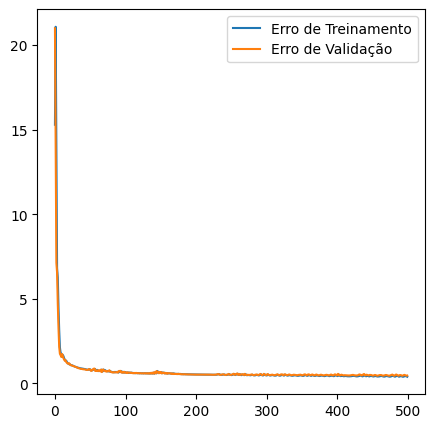

In [558]:
plt.figure(figsize=(5,5))
plt.plot(train_losses, label='Erro de Treinamento')
plt.plot(test_losses, label='Erro de Validação')
plt.legend()
plt.show()

In [560]:
class_predict_onehot = rna(data_test)
class_predict = class_predict_onehot.argmax(axis=1)
confusion_matriz = confusion_matrix(labels_test, class_predict, labels=range(3))
print("----- Matriz de Confusão - Dados de Teste -----")
confusion_matriz

----- Matriz de Confusão - Dados de Teste -----


array([[84,  3,  0],
       [10, 74, 16],
       [ 0, 16, 82]], dtype=int64)